In [1]:
# load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba)
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(here)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


── Attaching packages ───────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ──────────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

In [2]:
# load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba)
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(here)


working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/sorghum_bicolor"

# load arguments
#args <- commandArgs(T)
#if(length(args)!=5){stop("Rscript normGBA.R <gene.sparse> <meta> <Zea_mays.AGPv4.36.Allgene.nuclear.bed> <prefix> <F>")}
#input_data <- as.character(args[1])
#meta <- as.character(args[2])
#gene <- as.character(args[3])
#prefix <- as.character(args[4])



#gene_bodysorghum_bicolor_tis_leaf_nmf_step_2_knn_27.out.de_novo.rds
input <- here(working_dir,"00.data/sorghum_bicolor.gene_body_acc_leaf_v3_clustering_strict.counts.txt")
#input_2 <- here("/home/jpm73279/r_script_dev/lw_plotting","zea_mays.normalized_gene_acc_scores.leaf_svd_knn_100_strict.GBaccessibility.sparse")
meta <- here(working_dir,"00.data/Sb_leaf.V3_final.txt")
gene <- here("/scratch/jpm73279/comparative_single_cell/09.ortholog_heatmap/00.data/Sb.De_novo_zm.test.markers.final.bed")
gene_DA <- here(working_dir,"00.data/Sbicolorv5.1.gene.bed")
#prefix <- "TEST_SORGHUM_TEST"

meta_data <- read.delim(meta)
gene_markers <- read.delim(gene)
gene_markers <- gene_markers  %>%
    arrange(type)

all_markers <- gene_markers$geneID

raw_cpm_counts_all_genes <- read_delim(input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)

colnames(meta_data)

merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(V3_annotation_n, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
merged_meta_cpm_information_copied <- merged_meta_cpm_information
catch <- merged_meta_cpm_information_copied  %>%
    group_by(V3_annotation_n) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()



caught_values <- as_tibble(catch)
see <- ungroup(merged_meta_cpm_information_copied)
merged_meta_cpm_information_copied<- bind_cols(merged_meta_cpm_information_copied,caught_values)  %>% 
    rename(grouped_CPM = value)

Rows: 35643126 Columns: 3
── Column specification ──────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "cellID"                    "total"                    
 [3] "tss"                       "acrs"                     
 [5] "ptmt"                      "nSites"                   
 [7] "log10nSites"               "sampleID"                 
 [9] "umap1"                     "umap2"                    
[11] "doubletscore"              "d.type"                   
[13] "LouvainClusters"           "cell_annotation_glmnet"   
[15] "cell_annotation_knn"       "cell_annotation_enrich"   
[17] "cell_annotation_smooth"    "cluster_annotation_glmnet"
[19] "cluster_annotation_knn"    "cluster_annotation_smooth"
[21] "cluster_annotation_enrich" "LouvainClusters_t"        
[23] "V3_final_annnotation"      "total_cell_count"         
[25] "V3_annotation_n"

`summarise()` has grouped output by 'V3_annotation_n'. You can override using the
`.groups` argument.


In [3]:
# Create Proportion Cells Accessible Metrics ------------------------------
merged_meta_cellID_values <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))
take_unq_genes <- unique(merged_meta_cellID_values$geneID)


merged_meta_cellID_values_all_genes <- merged_meta_cellID_values %>% 
    select(cellID, V3_annotation_n, accessability, geneID) 

In [4]:
head(merged_meta_cpm_information_copied)
altered_deseq2 <- merged_meta_cpm_information_copied %>% 
    dplyr::select(-counts) %>% 
    pivot_wider(names_from = geneID, values_from = grouped_CPM, values_fill = 0) %>% 
    pivot_longer(cols = -V3_annotation_n, names_to = "geneID", values_to = "grouped_CPM") %>% 
    group_by(geneID) %>% 
    mutate(Zscore = scale(grouped_CPM)) %>% 
    ungroup()  %>% 
    #mutate(relative_accessability = rescale(Zscore, to = c(0,1))) %>% 
    group_by(V3_annotation_n)  %>% 
    mutate(Zscore_group = scale(Zscore))

V3_annotation_n,geneID,counts,grouped_CPM
<chr>,<chr>,<dbl>,<dbl>
bundle_sheath_ncell_1770,888jpa7.g114936.t1.g,10,1.394769
bundle_sheath_ncell_1770,888jpa7.g116981.t1.g,20,2.789537
bundle_sheath_ncell_1770,888jpa7.g117717.t1.g,558,77.828089
bundle_sheath_ncell_1770,888jpa7.g121623.t1.g,117,16.318793
bundle_sheath_ncell_1770,888jpa7.g135363.t1.g,44,6.136982
bundle_sheath_ncell_1770,888jpa7.g135679.t1.g,126,17.574085


In [5]:
colnames(merged_meta_cellID_values_all_genes)
colnames(merged_meta_cellID_values_all_genes)

wider_all_genes_altered <- merged_meta_cellID_values_all_genes %>% 
                    distinct()  %>% 
                    pivot_wider(names_from = geneID, 
                                values_from = accessability,  
                                values_fill = 0) %>% 
                    pivot_longer(cols = c(-V3_annotation_n, -cellID), 
                                 names_to = "geneID", 
                                 values_to = "accessability") %>% 
                    mutate(expression_bool = case_when(accessability < 1 ~ 0,
                                                       accessability >= 1 ~ 1)) %>% 
                    group_by(V3_annotation_n, geneID) %>% 
                    summarise(total_cells = n(), 
                              proportion_expressing = (sum(expression_bool)/total_cells * 100))


#colnames(merged_meta_cellID_values_all_genes)
#merged_meta_cellID_values_all_genes %>% 
#    group_by(V3_annotation_n) %>% 
#    select(-accessability, -cellID) %>% 
#    unique() %>% 
#    summarise(count = n())

[1] "cellID"          "V3_annotation_n" "accessability"   "geneID"

[1] "cellID"          "V3_annotation_n" "accessability"   "geneID"

`summarise()` has grouped output by 'V3_annotation_n'. You can override using the
`.groups` argument.


In [6]:
marker_final_plotting <- left_join(altered_deseq2, wider_all_genes_altered, by = c("V3_annotation_n", "geneID")) %>% 
        left_join(., gene_markers, by = c("geneID"))

In [7]:
test_marker_clust <- marker_final_plotting  %>% 
    unique()  %>% 
    filter(geneID %in% gene_markers$geneID)  %>% 
    ungroup() %>% 
    dplyr::select(V3_annotation_n, Zscore, name)  %>% 
    pivot_wider(names_from = V3_annotation_n, values_from = Zscore) %>% 
      data.frame() # make df as tibbles -> matrix annoying

In [8]:
head(test_marker_clust)

,name,bundle_sheath_ncell_1770,companion_cell_ncell_460,epidermal_ncell_3543,ground_meristem_ncell_854,mesophyll_ncell_3425,protoderm_ncell_1814,sieve_element_ncell_962,subsidary_cell_ncell_220,unknown_ncell_1602,vascular_parenchyma_ncell_69,xylem_ncell_228
,<chr>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
1,Zm00001eb050930_pval_0_protoderm_ncell_1292,-0.9014985,-0.8366609,1.2817107,0.8504574,-0.4099267,1.4023755,-0.2773803,1.0442643,-0.2538151,-0.2603460,-1.6391804
2,Zm00001eb303780_pval_0_xylem_ncell_336,-0.2815825,-0.2977896,-0.5213085,-0.2248228,-0.1315553,0.2125725,-0.6750154,-0.4952363,2.6141738,-1.0724806,0.8730447
3,Zm00001eb313510_pval_0_epidermal_ncell_3135,-0.8549268,-0.9177147,1.9790094,0.6696753,-0.3604284,1.2375037,-0.9832722,0.7360104,-0.2125391,-0.5738937,-0.7194238
4,Zm00001eb318210_pval_0_vascular_parenchyma_ncell_1231,-0.1023600,0.1007073,-0.2677419,-0.1328344,0.2419584,-0.3512128,0.3330569,-0.9507577,1.9565411,-1.9175028,1.0901459
5,Zm00001eb126710_pval_0_xylem_ncell_336,-0.3985894,-0.3506793,-0.5007494,-0.5127678,-0.4823578,-0.4538451,-0.3702464,-0.4868886,1.6442568,-0.4333981,2.3452650
6,Zm00001eb368810_pval_0_unknown_ncell_574,-0.2082076,0.2740243,0.8855853,-0.2705940,0.7771568,0.4421690,-0.2866821,-1.5542465,-0.9494818,1.9332429,-1.0429664


In [9]:
row.names(test_marker_clust) <- test_marker_clust$name  # put gene in `row`
test_marker_clust <- test_marker_clust[,-1] #drop gene column as now in rows
clust <- hclust(dist(test_marker_clust %>% as.matrix())) # hclust with distance matrix

In [10]:
mat <- marker_final_plotting %>% 
    ungroup() %>% 
    unique()  %>% 
    filter(geneID %in% gene_markers$geneID)  %>% 
    dplyr::select(V3_annotation_n, Zscore, name)  %>% 
    pivot_wider(names_from = V3_annotation_n, values_from = Zscore) %>% 
      data.frame() # make df as tibbles -> matrix annoying



row.names(mat) <- mat$name  # put gene in `row`
mat <- mat[,-1] #drop gene column as now in rows
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix

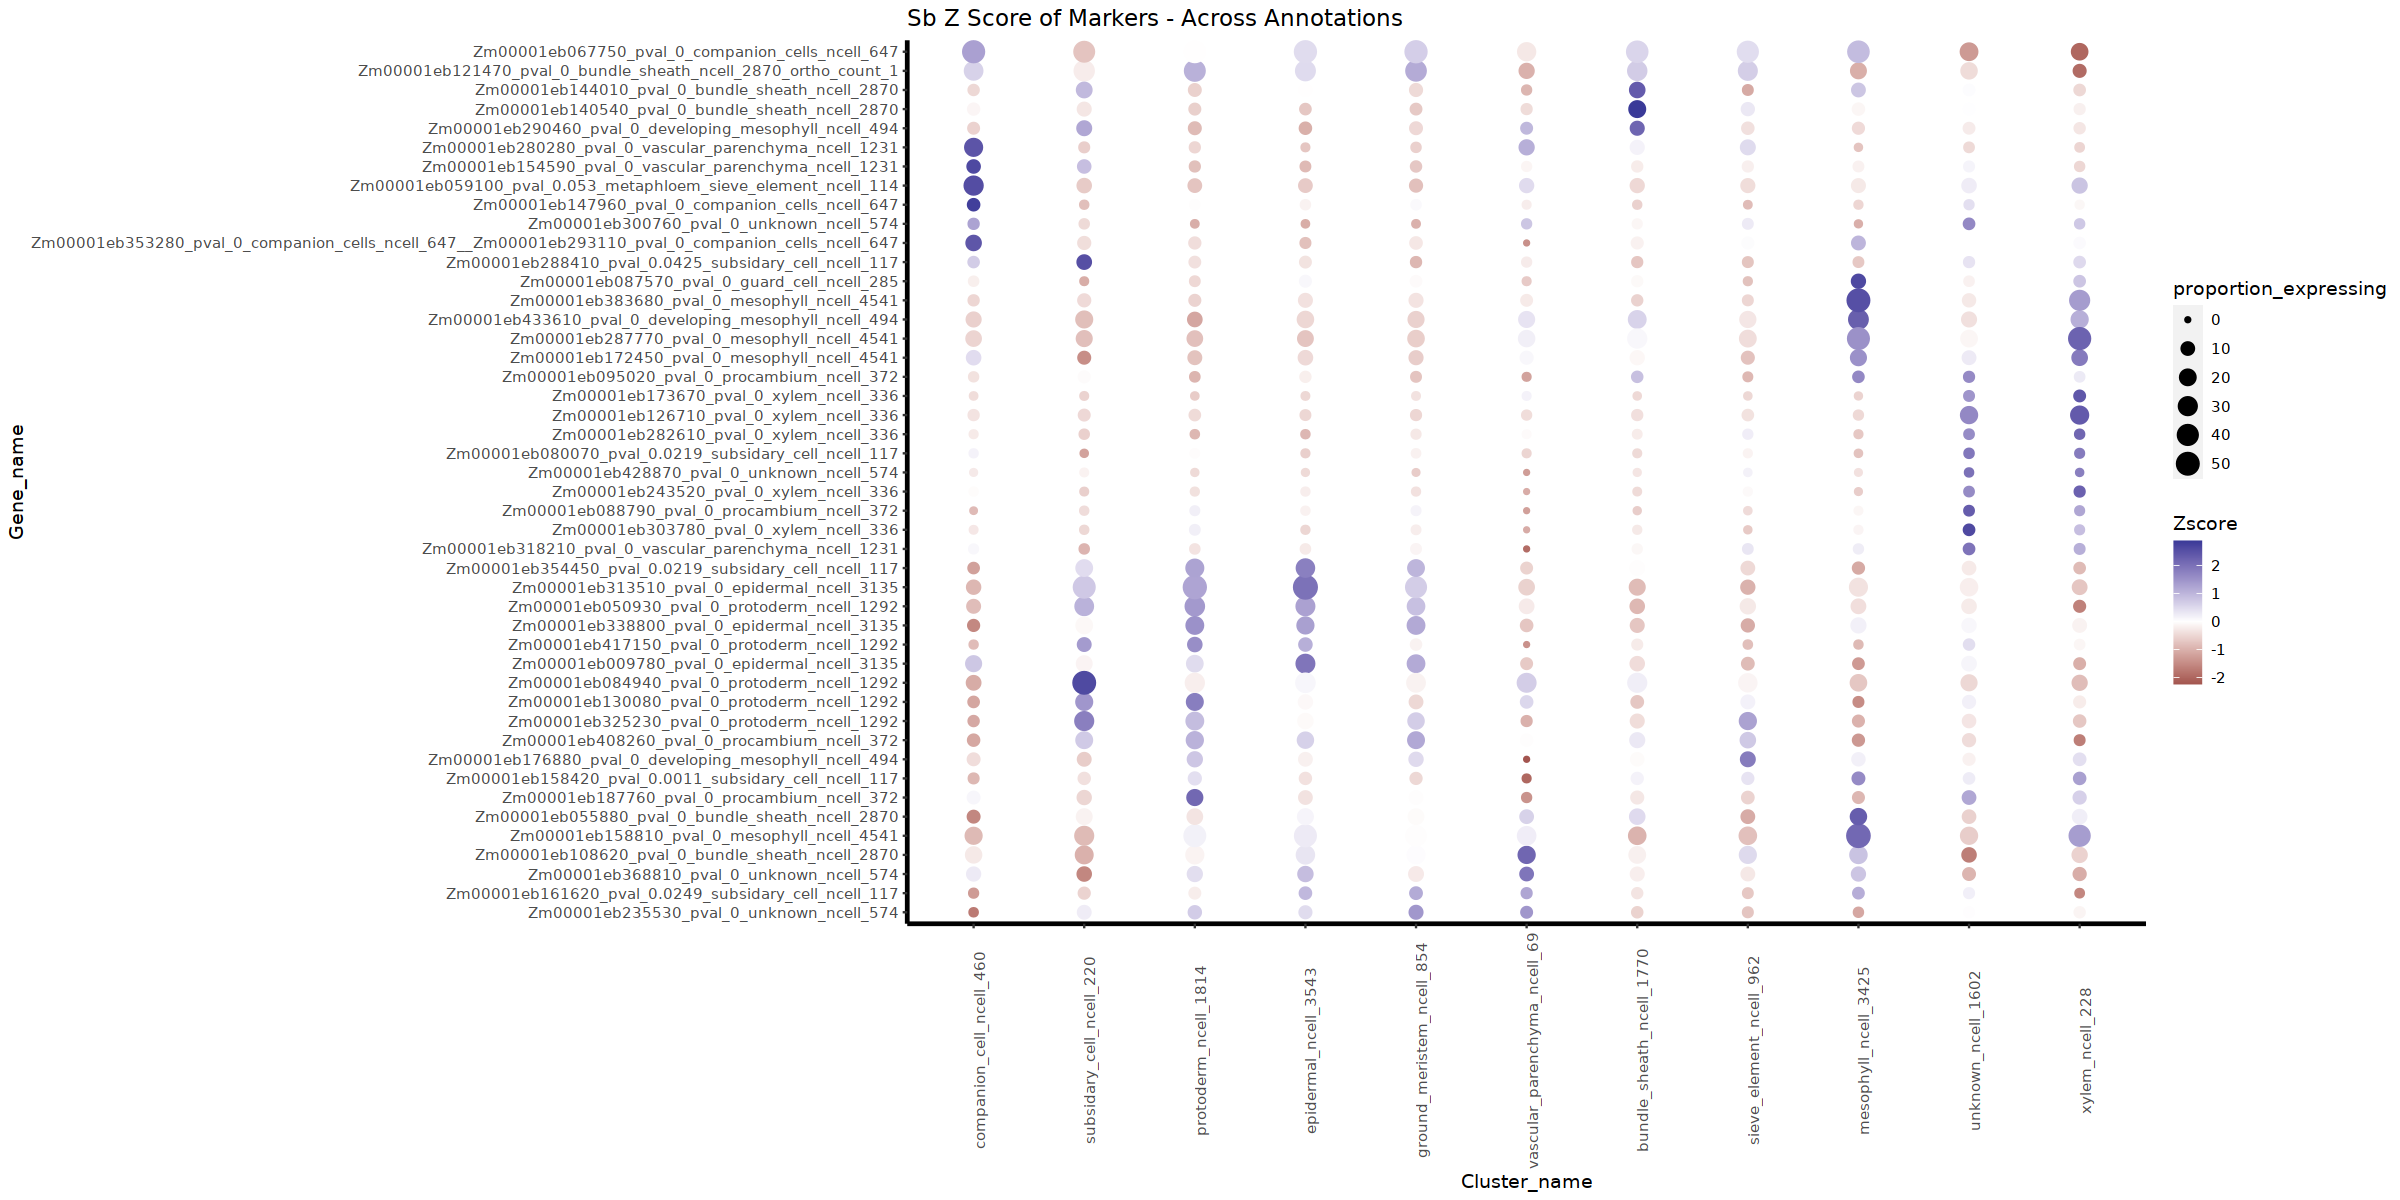

In [11]:
options(repr.plot.width=20, repr.plot.height=10)


marker_final_plotting  %>% 
    mutate(Gene_name = factor(name, clust$labels[clust$order]),
          Cluster_name = factor(V3_annotation_n, levels = v_clust$labels[v_clust$order])) %>% 
    filter(is.na(Gene_name) != TRUE) %>% 
    ggplot(., aes(x=Cluster_name, y = Gene_name, 
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line.x = element_line(color="black", size = 1), axis.line.y = element_line(color="black", size = 1)) +
    ggtitle("Sb Z Score of Markers - Across Annotations")





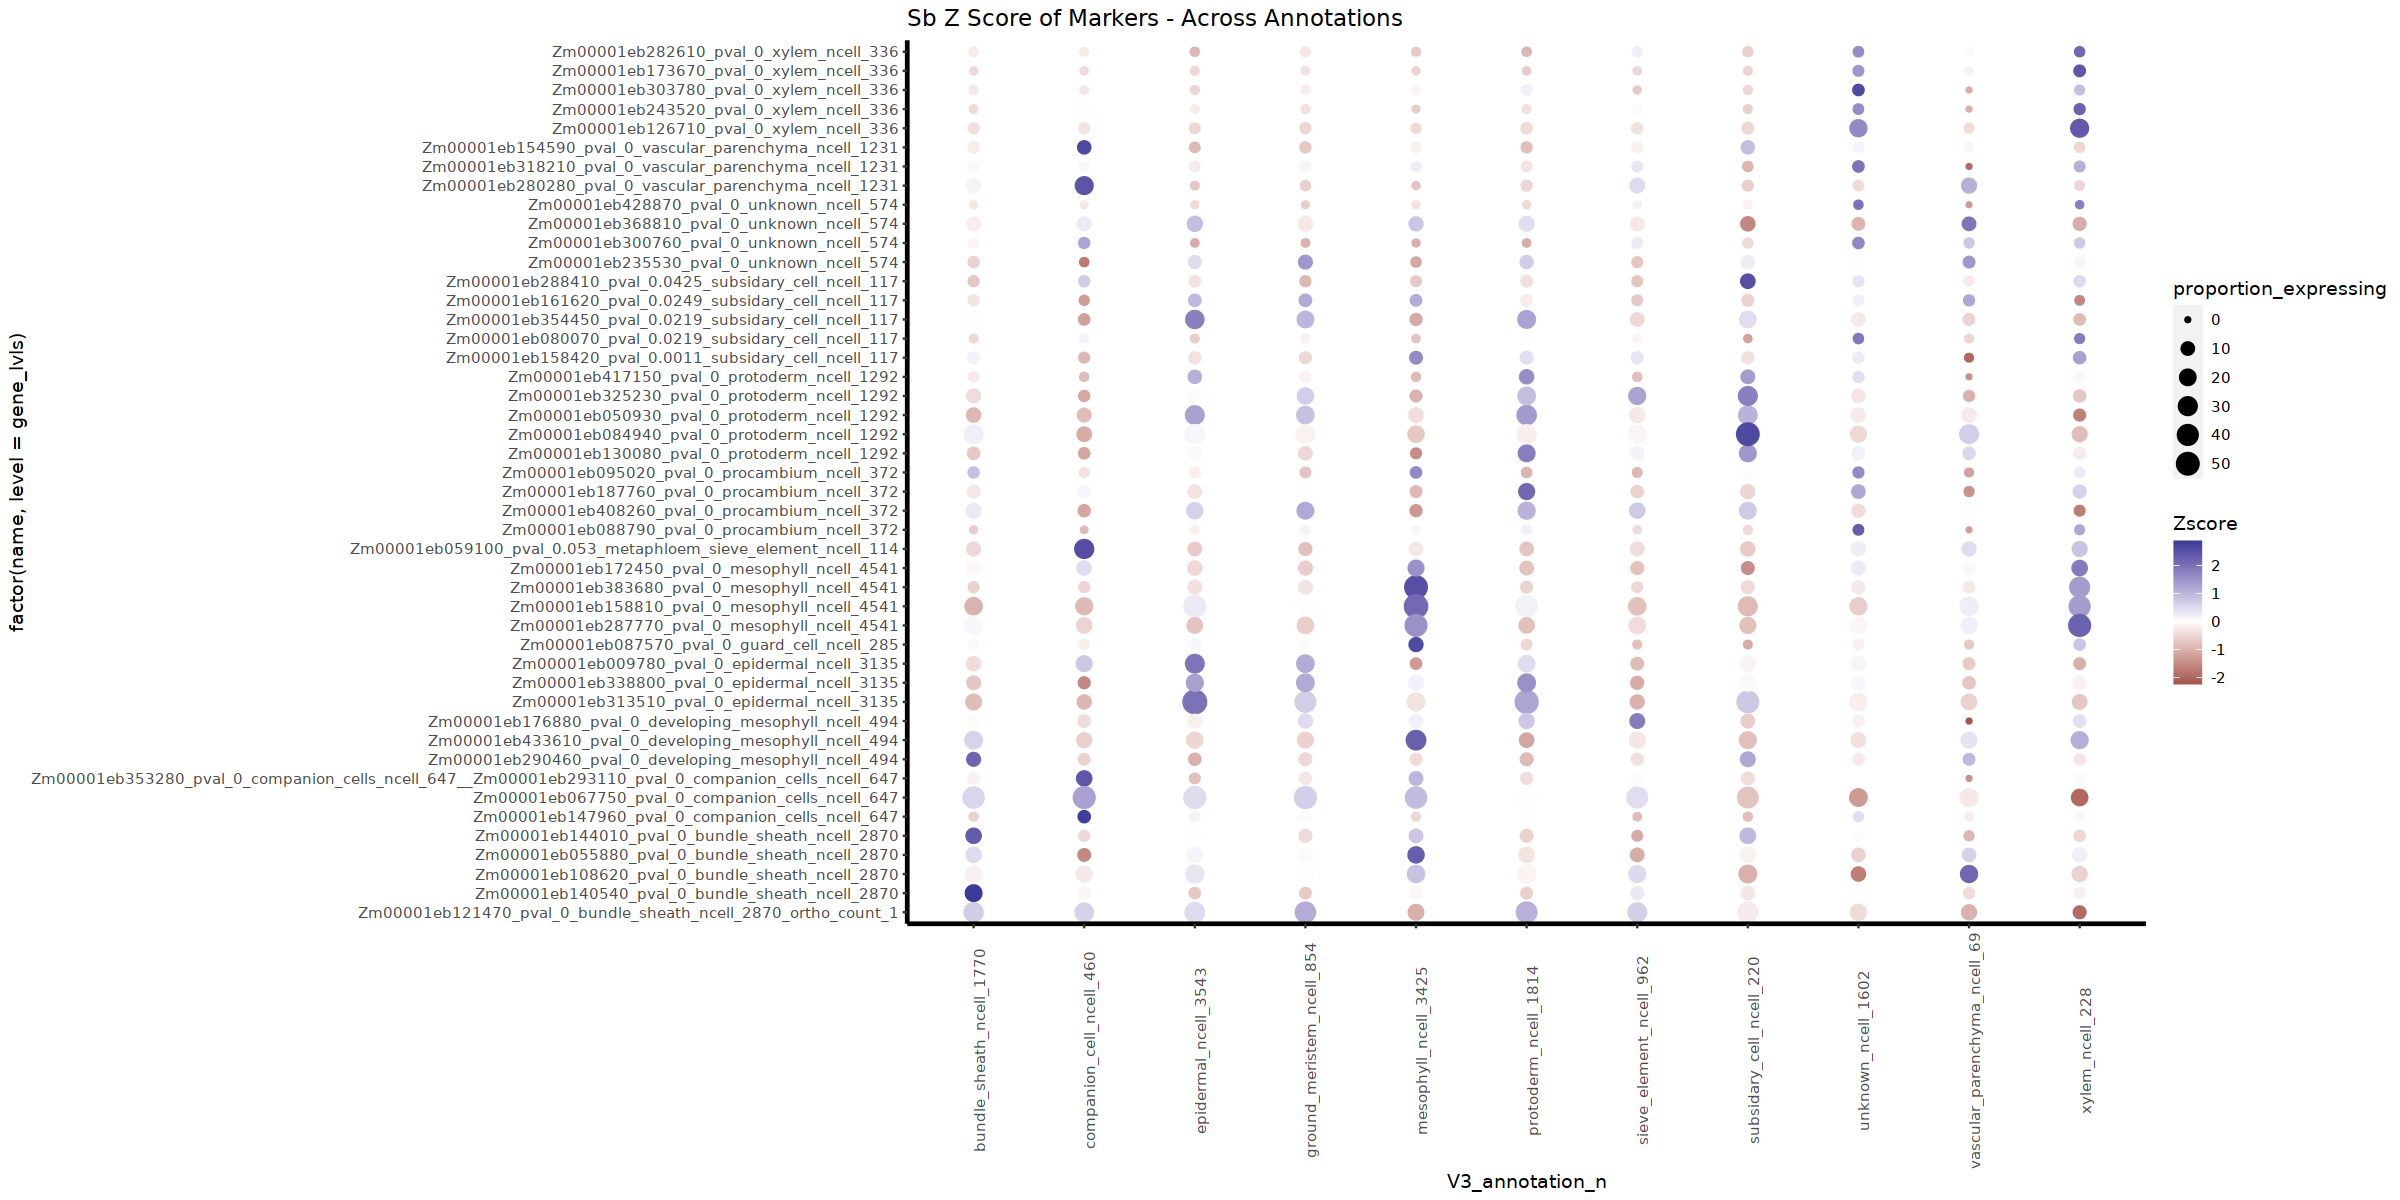

In [12]:
options(repr.plot.width=20, repr.plot.height=10)

gene_lvls <- c("Zm00001eb121470_pval_0_bundle_sheath_ncell_2870_ortho_count_1",
"Zm00001eb140540_pval_0_bundle_sheath_ncell_2870",
"Zm00001eb108620_pval_0_bundle_sheath_ncell_2870",
"Zm00001eb055880_pval_0_bundle_sheath_ncell_2870",
"Zm00001eb144010_pval_0_bundle_sheath_ncell_2870",
"Zm00001eb147960_pval_0_companion_cells_ncell_647",
"Zm00001eb067750_pval_0_companion_cells_ncell_647",
"Zm00001eb353280_pval_0_companion_cells_ncell_647__Zm00001eb293110_pval_0_companion_cells_ncell_647",
"Zm00001eb290460_pval_0_developing_mesophyll_ncell_494",
"Zm00001eb433610_pval_0_developing_mesophyll_ncell_494",
"Zm00001eb176880_pval_0_developing_mesophyll_ncell_494",
"Zm00001eb313510_pval_0_epidermal_ncell_3135",
"Zm00001eb338800_pval_0_epidermal_ncell_3135",
"Zm00001eb009780_pval_0_epidermal_ncell_3135",
"Zm00001eb087570_pval_0_guard_cell_ncell_285",
"Zm00001eb287770_pval_0_mesophyll_ncell_4541",
"Zm00001eb158810_pval_0_mesophyll_ncell_4541",
"Zm00001eb383680_pval_0_mesophyll_ncell_4541",
"Zm00001eb172450_pval_0_mesophyll_ncell_4541",
"Zm00001eb059100_pval_0.053_metaphloem_sieve_element_ncell_114",
"Zm00001eb088790_pval_0_procambium_ncell_372",
"Zm00001eb408260_pval_0_procambium_ncell_372",
"Zm00001eb187760_pval_0_procambium_ncell_372",
"Zm00001eb095020_pval_0_procambium_ncell_372",
"Zm00001eb130080_pval_0_protoderm_ncell_1292",
"Zm00001eb084940_pval_0_protoderm_ncell_1292",
"Zm00001eb050930_pval_0_protoderm_ncell_1292",
"Zm00001eb325230_pval_0_protoderm_ncell_1292",
"Zm00001eb417150_pval_0_protoderm_ncell_1292",
"Zm00001eb158420_pval_0.0011_subsidary_cell_ncell_117",
"Zm00001eb080070_pval_0.0219_subsidary_cell_ncell_117",
"Zm00001eb354450_pval_0.0219_subsidary_cell_ncell_117",
"Zm00001eb161620_pval_0.0249_subsidary_cell_ncell_117",
"Zm00001eb288410_pval_0.0425_subsidary_cell_ncell_117",
"Zm00001eb235530_pval_0_unknown_ncell_574",
"Zm00001eb300760_pval_0_unknown_ncell_574",
"Zm00001eb368810_pval_0_unknown_ncell_574",
"Zm00001eb428870_pval_0_unknown_ncell_574",
"Zm00001eb280280_pval_0_vascular_parenchyma_ncell_1231",
"Zm00001eb318210_pval_0_vascular_parenchyma_ncell_1231",
"Zm00001eb154590_pval_0_vascular_parenchyma_ncell_1231",
"Zm00001eb126710_pval_0_xylem_ncell_336",
"Zm00001eb243520_pval_0_xylem_ncell_336",
"Zm00001eb303780_pval_0_xylem_ncell_336",
"Zm00001eb173670_pval_0_xylem_ncell_336",
"Zm00001eb282610_pval_0_xylem_ncell_336")


marker_final_plotting  %>% 
    filter(is.na(name) != TRUE) %>% 
    ggplot(., aes(x=V3_annotation_n, y = factor(name, level = gene_lvls),
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line.x = element_line(color="black", size = 1), axis.line.y = element_line(color="black", size = 1)) +
    ggtitle("Sb Z Score of Markers - Across Annotations")





In [13]:
colnames(meta_data)

[1] "cellID"                    "total"                    
 [3] "tss"                       "acrs"                     
 [5] "ptmt"                      "nSites"                   
 [7] "log10nSites"               "sampleID"                 
 [9] "umap1"                     "umap2"                    
[11] "doubletscore"              "d.type"                   
[13] "LouvainClusters"           "cell_annotation_glmnet"   
[15] "cell_annotation_knn"       "cell_annotation_enrich"   
[17] "cell_annotation_smooth"    "cluster_annotation_glmnet"
[19] "cluster_annotation_knn"    "cluster_annotation_smooth"
[21] "cluster_annotation_enrich" "LouvainClusters_t"        
[23] "V3_final_annnotation"      "total_cell_count"         
[25] "V3_annotation_n"

In [14]:
merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(LouvainClusters_t, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
merged_meta_cpm_information_copied <- merged_meta_cpm_information
catch <- merged_meta_cpm_information_copied  %>%
    group_by(LouvainClusters_t) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()



caught_values <- as_tibble(catch)
see <- ungroup(merged_meta_cpm_information_copied)
merged_meta_cpm_information_copied<- bind_cols(merged_meta_cpm_information_copied,caught_values)  %>% 
    rename(grouped_CPM = value)

# Create Proportion Cells Accessible Metrics ------------------------------
merged_meta_cellID_values <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))
take_unq_genes <- unique(merged_meta_cellID_values$geneID)


merged_meta_cellID_values_all_genes <- merged_meta_cellID_values %>% 
    select(cellID, LouvainClusters_t, accessability, geneID) 


head(merged_meta_cpm_information_copied)
altered_deseq2 <- merged_meta_cpm_information_copied %>% 
    dplyr::select(-counts) %>% 
    pivot_wider(names_from = geneID, values_from = grouped_CPM, values_fill = 0) %>% 
    pivot_longer(cols = -LouvainClusters_t, names_to = "geneID", values_to = "grouped_CPM") %>% 
    group_by(geneID) %>% 
    mutate(Zscore = scale(grouped_CPM)) %>% 
    ungroup()  %>% 
    #mutate(relative_accessability = rescale(Zscore, to = c(0,1))) %>% 
    group_by(LouvainClusters_t)  %>% 
    mutate(Zscore_group = scale(Zscore))


colnames(merged_meta_cellID_values_all_genes)
colnames(merged_meta_cellID_values_all_genes)

wider_all_genes_altered <- merged_meta_cellID_values_all_genes %>% 
                    distinct()  %>% 
                    pivot_wider(names_from = geneID, 
                                values_from = accessability,  
                                values_fill = 0) %>% 
                    pivot_longer(cols = c(-LouvainClusters_t, -cellID), 
                                 names_to = "geneID", 
                                 values_to = "accessability") %>% 
                    mutate(expression_bool = case_when(accessability < 1 ~ 0,
                                                       accessability >= 1 ~ 1)) %>% 
                    group_by(LouvainClusters_t, geneID) %>% 
                    summarise(total_cells = n(), 
                              proportion_expressing = (sum(expression_bool)/total_cells * 100))


#colnames(merged_meta_cellID_values_all_genes)
#merged_meta_cellID_values_all_genes %>% 
#    group_by(V3_annotation_n) %>% 
#    select(-accessability, -cellID) %>% 
#    unique() %>% 
#    summarise(count = n())


marker_final_plotting <- left_join(altered_deseq2, wider_all_genes_altered, by = c("LouvainClusters_t", "geneID")) %>% 
        left_join(., gene_markers, by = c("geneID"))


test_marker_clust <- marker_final_plotting  %>% 
    unique()  %>% 
    filter(geneID %in% gene_markers$geneID)  %>% 
    ungroup() %>% 
    dplyr::select(LouvainClusters_t, Zscore, name)  %>% 
    pivot_wider(names_from = LouvainClusters_t, values_from = Zscore) %>% 
      data.frame() # make df as tibbles -> matrix annoying

`summarise()` has grouped output by 'LouvainClusters_t'. You can override using
the `.groups` argument.


LouvainClusters_t,geneID,counts,grouped_CPM
<int>,<chr>,<dbl>,<dbl>
1,888jpa7.g114936.t1.g,30,2.882715
1,888jpa7.g116981.t1.g,132,12.683946
1,888jpa7.g117717.t1.g,606,58.230843
1,888jpa7.g121623.t1.g,120,11.530860
1,888jpa7.g135363.t1.g,157,15.086209
1,888jpa7.g135679.t1.g,152,14.605756


[1] "cellID"            "LouvainClusters_t" "accessability"    
[4] "geneID"

[1] "cellID"            "LouvainClusters_t" "accessability"    
[4] "geneID"

`summarise()` has grouped output by 'LouvainClusters_t'. You can override using
the `.groups` argument.


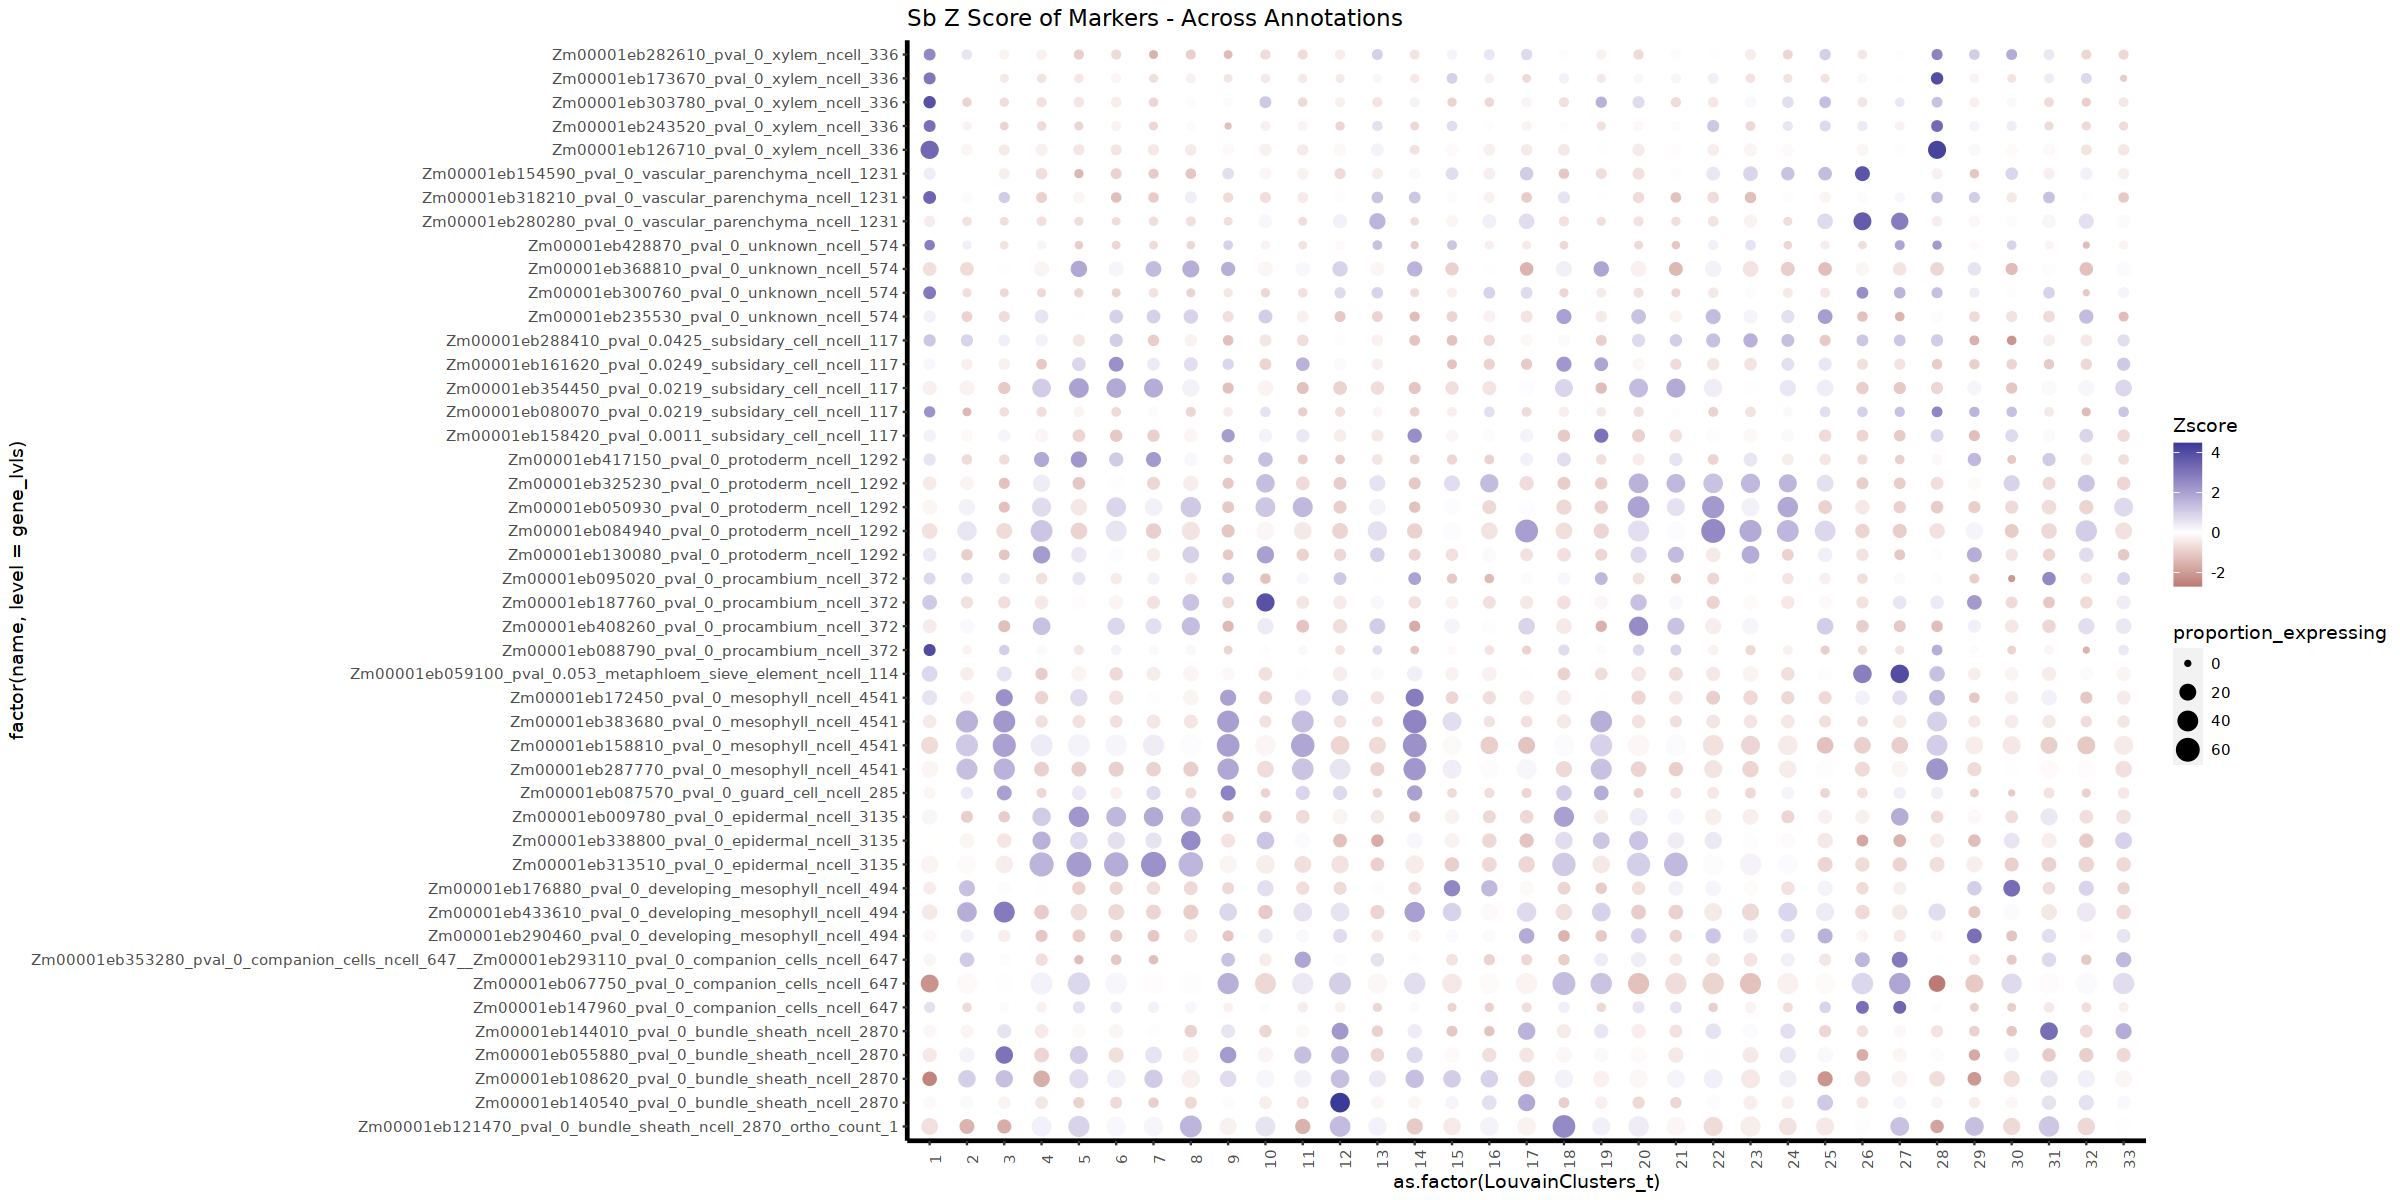

In [15]:
options(repr.plot.width=20, repr.plot.height=10)

gene_lvls <- c("Zm00001eb121470_pval_0_bundle_sheath_ncell_2870_ortho_count_1",
"Zm00001eb140540_pval_0_bundle_sheath_ncell_2870",
"Zm00001eb108620_pval_0_bundle_sheath_ncell_2870",
"Zm00001eb055880_pval_0_bundle_sheath_ncell_2870",
"Zm00001eb144010_pval_0_bundle_sheath_ncell_2870",
"Zm00001eb147960_pval_0_companion_cells_ncell_647",
"Zm00001eb067750_pval_0_companion_cells_ncell_647",
"Zm00001eb353280_pval_0_companion_cells_ncell_647__Zm00001eb293110_pval_0_companion_cells_ncell_647",
"Zm00001eb290460_pval_0_developing_mesophyll_ncell_494",
"Zm00001eb433610_pval_0_developing_mesophyll_ncell_494",
"Zm00001eb176880_pval_0_developing_mesophyll_ncell_494",
"Zm00001eb313510_pval_0_epidermal_ncell_3135",
"Zm00001eb338800_pval_0_epidermal_ncell_3135",
"Zm00001eb009780_pval_0_epidermal_ncell_3135",
"Zm00001eb087570_pval_0_guard_cell_ncell_285",
"Zm00001eb287770_pval_0_mesophyll_ncell_4541",
"Zm00001eb158810_pval_0_mesophyll_ncell_4541",
"Zm00001eb383680_pval_0_mesophyll_ncell_4541",
"Zm00001eb172450_pval_0_mesophyll_ncell_4541",
"Zm00001eb059100_pval_0.053_metaphloem_sieve_element_ncell_114",
"Zm00001eb088790_pval_0_procambium_ncell_372",
"Zm00001eb408260_pval_0_procambium_ncell_372",
"Zm00001eb187760_pval_0_procambium_ncell_372",
"Zm00001eb095020_pval_0_procambium_ncell_372",
"Zm00001eb130080_pval_0_protoderm_ncell_1292",
"Zm00001eb084940_pval_0_protoderm_ncell_1292",
"Zm00001eb050930_pval_0_protoderm_ncell_1292",
"Zm00001eb325230_pval_0_protoderm_ncell_1292",
"Zm00001eb417150_pval_0_protoderm_ncell_1292",
"Zm00001eb158420_pval_0.0011_subsidary_cell_ncell_117",
"Zm00001eb080070_pval_0.0219_subsidary_cell_ncell_117",
"Zm00001eb354450_pval_0.0219_subsidary_cell_ncell_117",
"Zm00001eb161620_pval_0.0249_subsidary_cell_ncell_117",
"Zm00001eb288410_pval_0.0425_subsidary_cell_ncell_117",
"Zm00001eb235530_pval_0_unknown_ncell_574",
"Zm00001eb300760_pval_0_unknown_ncell_574",
"Zm00001eb368810_pval_0_unknown_ncell_574",
"Zm00001eb428870_pval_0_unknown_ncell_574",
"Zm00001eb280280_pval_0_vascular_parenchyma_ncell_1231",
"Zm00001eb318210_pval_0_vascular_parenchyma_ncell_1231",
"Zm00001eb154590_pval_0_vascular_parenchyma_ncell_1231",
"Zm00001eb126710_pval_0_xylem_ncell_336",
"Zm00001eb243520_pval_0_xylem_ncell_336",
"Zm00001eb303780_pval_0_xylem_ncell_336",
"Zm00001eb173670_pval_0_xylem_ncell_336",
"Zm00001eb282610_pval_0_xylem_ncell_336")


marker_final_plotting  %>% 
    filter(is.na(name) != TRUE) %>% 
    ggplot(., aes(x=as.factor(LouvainClusters_t), y = factor(name, level = gene_lvls),
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line.x = element_line(color="black", size = 1), axis.line.y = element_line(color="black", size = 1)) +
    ggtitle("Sb Z Score of Markers - Across Annotations")





In [22]:
epidermal_meta_sub_cluster <- read.delim("/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/Sb_leaf_svd.V3.subclustering.compressed_markers.epidermal.V2.meta.txt")


merged_meta_cpm_information <- left_join(epidermal_meta_sub_cluster, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(LouvainClusters, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
merged_meta_cpm_information_copied <- merged_meta_cpm_information
catch <- merged_meta_cpm_information_copied  %>%
    group_by(LouvainClusters) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()



caught_values <- as_tibble(catch)
see <- ungroup(merged_meta_cpm_information_copied)
merged_meta_cpm_information_copied<- bind_cols(merged_meta_cpm_information_copied,caught_values)  %>% 
    rename(grouped_CPM = value)

# Create Proportion Cells Accessible Metrics ------------------------------
merged_meta_cellID_values <- left_join(epidermal_meta_sub_cluster, raw_cpm_counts_all_genes, by = c("cellID"))
take_unq_genes <- unique(merged_meta_cellID_values$geneID)


merged_meta_cellID_values_all_genes <- merged_meta_cellID_values %>% 
    select(cellID, LouvainClusters, accessability, geneID) 


head(merged_meta_cpm_information_copied)
altered_deseq2 <- merged_meta_cpm_information_copied %>% 
    dplyr::select(-counts) %>% 
    pivot_wider(names_from = geneID, values_from = grouped_CPM, values_fill = 0) %>% 
    pivot_longer(cols = -LouvainClusters, names_to = "geneID", values_to = "grouped_CPM") %>% 
    group_by(geneID) %>% 
    mutate(Zscore = scale(grouped_CPM)) %>% 
    ungroup()  %>% 
    #mutate(relative_accessability = rescale(Zscore, to = c(0,1))) %>% 
    group_by(LouvainClusters)  %>% 
    mutate(Zscore_group = scale(Zscore))


colnames(merged_meta_cellID_values_all_genes)
colnames(merged_meta_cellID_values_all_genes)

wider_all_genes_altered <- merged_meta_cellID_values_all_genes %>% 
                    distinct()  %>% 
                    pivot_wider(names_from = geneID, 
                                values_from = accessability,  
                                values_fill = 0) %>% 
                    pivot_longer(cols = c(-LouvainClusters, -cellID), 
                                 names_to = "geneID", 
                                 values_to = "accessability") %>% 
                    mutate(expression_bool = case_when(accessability < 1 ~ 0,
                                                       accessability >= 1 ~ 1)) %>% 
                    group_by(LouvainClusters, geneID) %>% 
                    summarise(total_cells = n(), 
                              proportion_expressing = (sum(expression_bool)/total_cells * 100))


#colnames(merged_meta_cellID_values_all_genes)
#merged_meta_cellID_values_all_genes %>% 
#    group_by(V3_annotation_n) %>% 
#    select(-accessability, -cellID) %>% 
#    unique() %>% 
#    summarise(count = n())


marker_final_plotting <- left_join(altered_deseq2, wider_all_genes_altered, by = c("LouvainClusters", "geneID")) %>% 
        left_join(., gene_markers, by = c("geneID"))


test_marker_clust <- marker_final_plotting  %>% 
    unique()  %>% 
    filter(geneID %in% gene_markers$geneID)  %>% 
    ungroup() %>% 
    dplyr::select(LouvainClusters, Zscore, name)  %>% 
    pivot_wider(names_from = LouvainClusters, values_from = Zscore) %>% 
      data.frame() # make df as tibbles -> matrix annoying

`summarise()` has grouped output by 'LouvainClusters'. You can override using the
`.groups` argument.


LouvainClusters,geneID,counts,grouped_CPM
<int>,<chr>,<dbl>,<dbl>
1,888jpa7.g114936.t1.g,12,3.026908
1,888jpa7.g116981.t1.g,48,12.107631
1,888jpa7.g117717.t1.g,228,57.511246
1,888jpa7.g121623.t1.g,40,10.089692
1,888jpa7.g135363.t1.g,55,13.873327
1,888jpa7.g135679.t1.g,53,13.368842


[1] "cellID"          "LouvainClusters" "accessability"   "geneID"

[1] "cellID"          "LouvainClusters" "accessability"   "geneID"

`summarise()` has grouped output by 'LouvainClusters'. You can override using the
`.groups` argument.


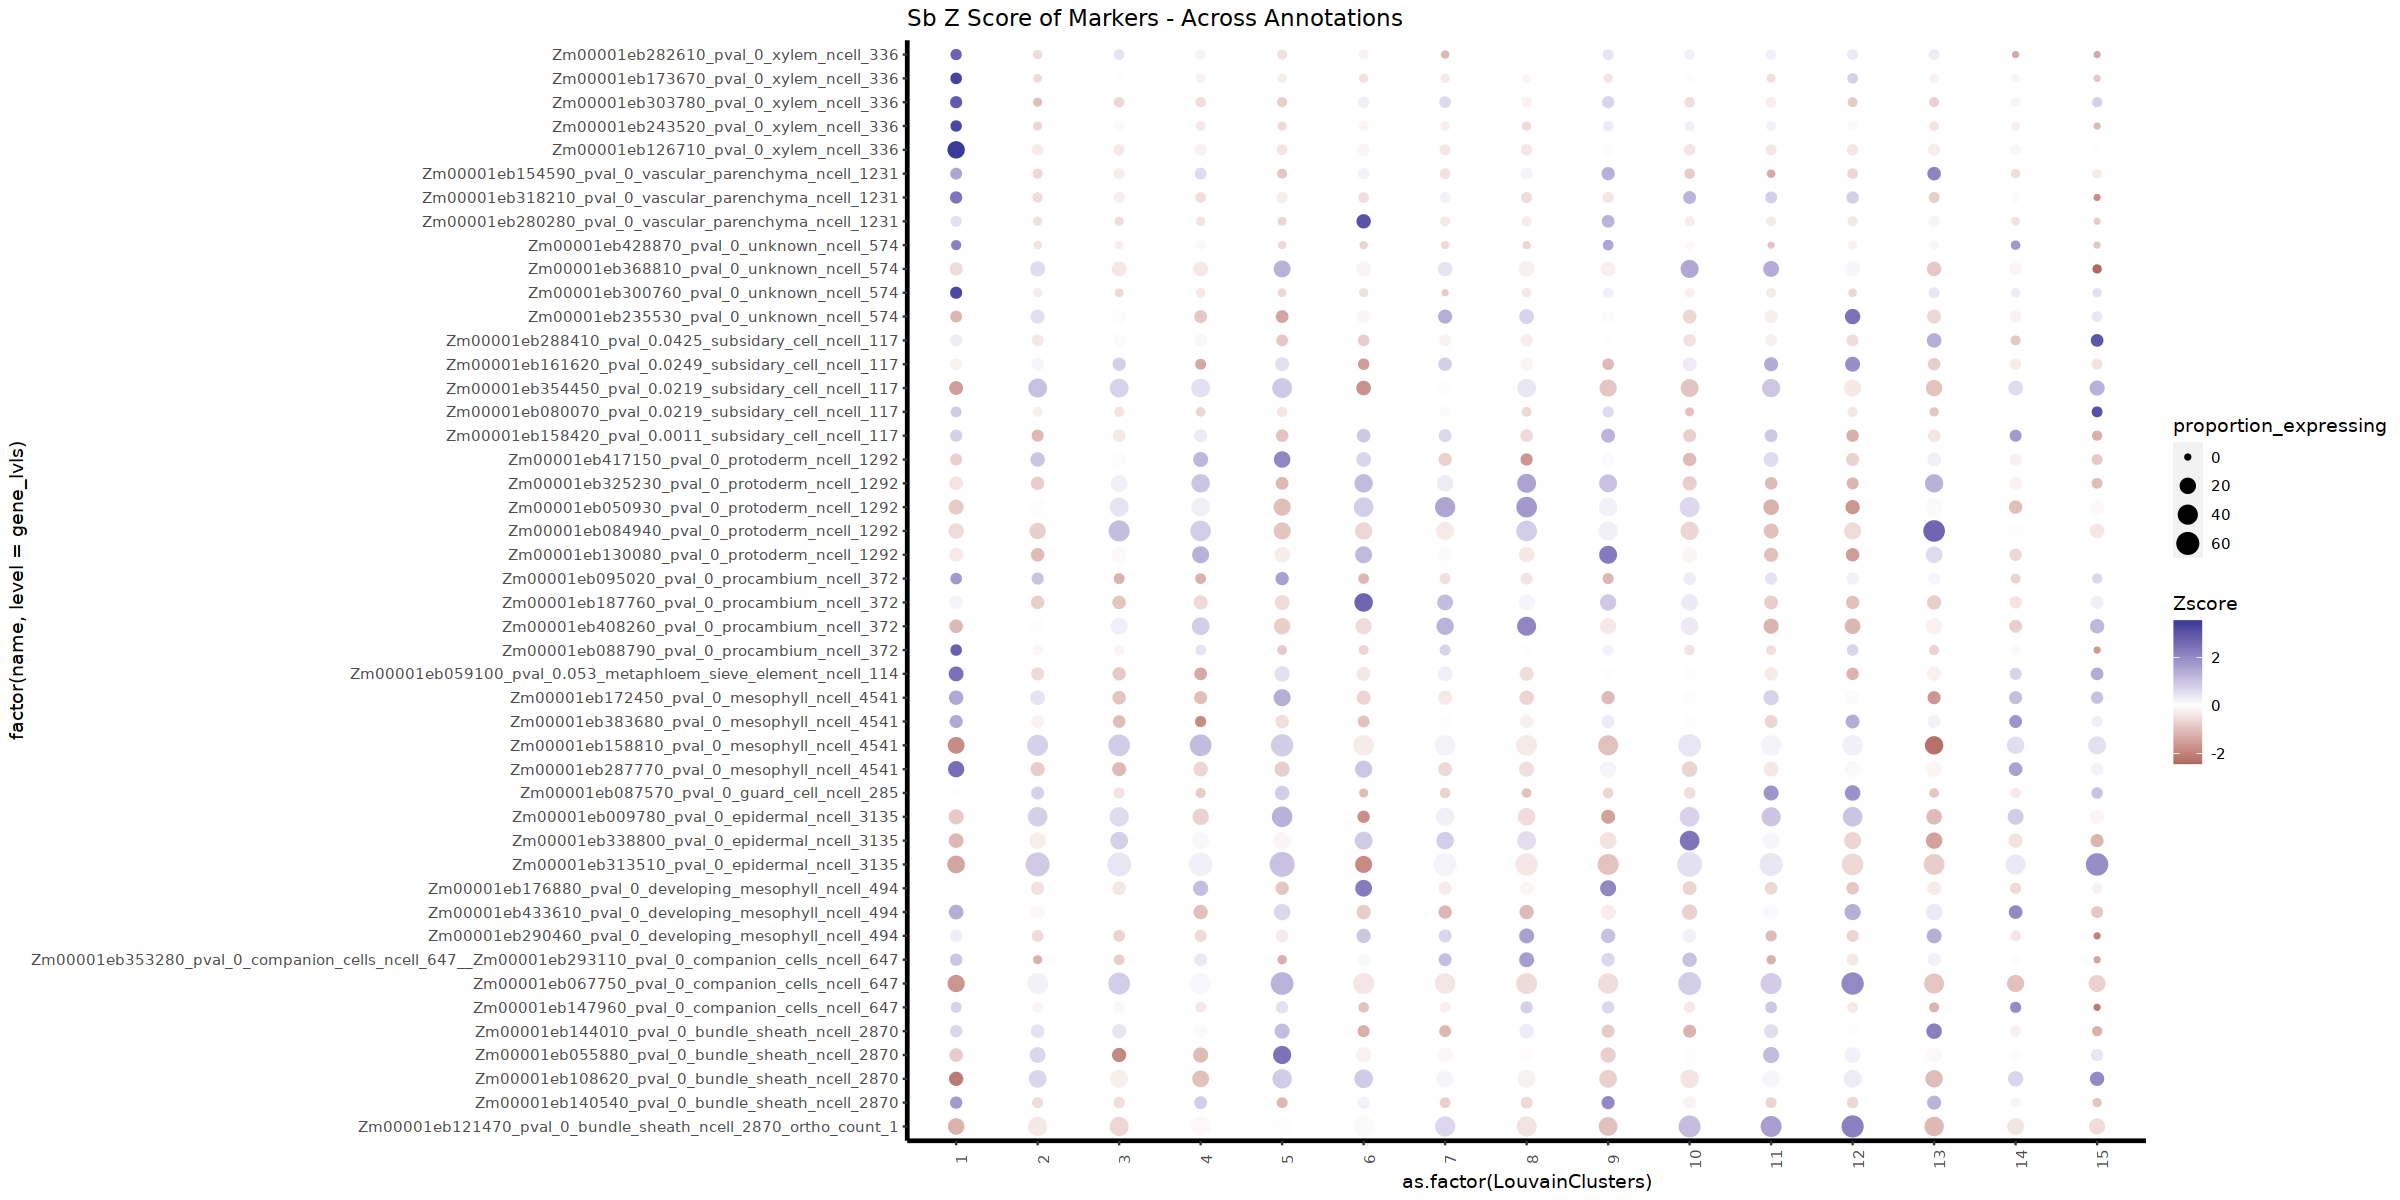

In [23]:
options(repr.plot.width=20, repr.plot.height=10)

gene_lvls <- c("Zm00001eb121470_pval_0_bundle_sheath_ncell_2870_ortho_count_1",
"Zm00001eb140540_pval_0_bundle_sheath_ncell_2870",
"Zm00001eb108620_pval_0_bundle_sheath_ncell_2870",
"Zm00001eb055880_pval_0_bundle_sheath_ncell_2870",
"Zm00001eb144010_pval_0_bundle_sheath_ncell_2870",
"Zm00001eb147960_pval_0_companion_cells_ncell_647",
"Zm00001eb067750_pval_0_companion_cells_ncell_647",
"Zm00001eb353280_pval_0_companion_cells_ncell_647__Zm00001eb293110_pval_0_companion_cells_ncell_647",
"Zm00001eb290460_pval_0_developing_mesophyll_ncell_494",
"Zm00001eb433610_pval_0_developing_mesophyll_ncell_494",
"Zm00001eb176880_pval_0_developing_mesophyll_ncell_494",
"Zm00001eb313510_pval_0_epidermal_ncell_3135",
"Zm00001eb338800_pval_0_epidermal_ncell_3135",
"Zm00001eb009780_pval_0_epidermal_ncell_3135",
"Zm00001eb087570_pval_0_guard_cell_ncell_285",
"Zm00001eb287770_pval_0_mesophyll_ncell_4541",
"Zm00001eb158810_pval_0_mesophyll_ncell_4541",
"Zm00001eb383680_pval_0_mesophyll_ncell_4541",
"Zm00001eb172450_pval_0_mesophyll_ncell_4541",
"Zm00001eb059100_pval_0.053_metaphloem_sieve_element_ncell_114",
"Zm00001eb088790_pval_0_procambium_ncell_372",
"Zm00001eb408260_pval_0_procambium_ncell_372",
"Zm00001eb187760_pval_0_procambium_ncell_372",
"Zm00001eb095020_pval_0_procambium_ncell_372",
"Zm00001eb130080_pval_0_protoderm_ncell_1292",
"Zm00001eb084940_pval_0_protoderm_ncell_1292",
"Zm00001eb050930_pval_0_protoderm_ncell_1292",
"Zm00001eb325230_pval_0_protoderm_ncell_1292",
"Zm00001eb417150_pval_0_protoderm_ncell_1292",
"Zm00001eb158420_pval_0.0011_subsidary_cell_ncell_117",
"Zm00001eb080070_pval_0.0219_subsidary_cell_ncell_117",
"Zm00001eb354450_pval_0.0219_subsidary_cell_ncell_117",
"Zm00001eb161620_pval_0.0249_subsidary_cell_ncell_117",
"Zm00001eb288410_pval_0.0425_subsidary_cell_ncell_117",
"Zm00001eb235530_pval_0_unknown_ncell_574",
"Zm00001eb300760_pval_0_unknown_ncell_574",
"Zm00001eb368810_pval_0_unknown_ncell_574",
"Zm00001eb428870_pval_0_unknown_ncell_574",
"Zm00001eb280280_pval_0_vascular_parenchyma_ncell_1231",
"Zm00001eb318210_pval_0_vascular_parenchyma_ncell_1231",
"Zm00001eb154590_pval_0_vascular_parenchyma_ncell_1231",
"Zm00001eb126710_pval_0_xylem_ncell_336",
"Zm00001eb243520_pval_0_xylem_ncell_336",
"Zm00001eb303780_pval_0_xylem_ncell_336",
"Zm00001eb173670_pval_0_xylem_ncell_336",
"Zm00001eb282610_pval_0_xylem_ncell_336")


marker_final_plotting  %>% 
    filter(is.na(name) != TRUE) %>% 
    ggplot(., aes(x=as.factor(LouvainClusters), y = factor(name, level = gene_lvls),
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line.x = element_line(color="black", size = 1), axis.line.y = element_line(color="black", size = 1)) +
    ggtitle("Sb Z Score of Markers - Across Annotations")





In [17]:
colnames(epidermal_meta_sub_cluster)

[1] "cellID"                    "total"                    
 [3] "tss"                       "acrs"                     
 [5] "ptmt"                      "nSites"                   
 [7] "log10nSites"               "sampleID"                 
 [9] "umap1"                     "umap2"                    
[11] "doubletscore"              "d.type"                   
[13] "LouvainClusters"           "Louvain_cluster_safe"     
[15] "cell_annotation_glmnet"    "cell_annotation_knn"      
[17] "cell_annotation_enrich"    "cell_annotation_smooth"   
[19] "cluster_annotation_glmnet" "cluster_annotation_knn"   
[21] "cluster_annotation_smooth" "cluster_annotation_enrich"